## Figures 3 and S8

### This script produces the P. pacificus plot in Figure 3, but was used to make all the plots in Figures 3 and S8, which were put together in Illustrator.

In [1]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns

import cooler
import bioframe

import cooltools
import cooltools.expected
from cooltools import snipping

import cooltools.lib.plotting
# Set up parallelization
import multiprocess

from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
from scipy import interpolate
from mpl_toolkits.axes_grid import make_axes_locatable
import pyBigWig
import csv

from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan

# Import python package for working with cooler files and tools for analysis
from cooltools.insulation import calculate_insulation_score, find_boundaries

# check the version (0.4.0)
cooltools.__version__ 

/state/partition1/job-436604/ipykernel_1543443/4289325635.py:22: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import make_axes_locatable


'0.4.0'

In [2]:
file="PS312_JK88_JK122_PRJNA12644-WBPS16-RS"

bin = str(5000) # resolution of cool file to load in base pairs

# load cool file
ppaclr = cooler.Cooler("".join(["/home/aa7013/hic-to-cool/",file,"/",file,"_30_",bin,"_raw.cool"]))

Load chrom.sizes files

In [3]:
chr=bioframe.read_table('/home/aa7013/hic-to-cool/chrom-sizes_files/pristionchus_pacificus.PRJNA12644.WBPS16.genomic.RS.chrom.sizes',schema='bed3')
chr=bioframe.parse_regions(chr)

print(chr)

  chrom  start       end            name
0     I      0  39556110    I:0-39556110
1    IV      0  30938908   IV:0-30938908
2     V      0  23911096    V:0-23911096
3    II      0  23310661   II:0-23310661
4   III      0  21666382  III:0-21666382
5     X      0  17126273    X:0-17126273


Define functions to measure P(s) and its derivative (taken from cooltools)

In [4]:
# a home-made wrapper around scaling distance decay curve and its derivative. See cooltools for more details
# returns 2 outputs, P(s) and its derivative

def scaling_agg(input_clr,input_regions):
    cvd = cooltools.expected.diagsum(
        clr=input_clr,
        regions=input_regions,
        transforms={'balanced': lambda p: p['count']*p['weight1']*p['weight2']}
    )
    lb_cvd, lb_slopes, lb_distbins = cooltools.expected.logbin_expected(cvd) #bins_per_order_magnitude=20 to get more dots
    lb_cvd_agg, lb_slopes_agg = cooltools.expected.combine_binned_expected(
        lb_cvd,
        binned_exp_slope=lb_slopes
    )
    lb_cvd_agg['s_bp'] = lb_cvd_agg['diag.avg'] * input_clr.binsize
    lb_slopes_agg['s_bp'] = lb_slopes_agg['diag.avg'] * input_clr.binsize
    return(lb_cvd_agg,lb_slopes_agg)

Measure P(s) and its derivative

In [5]:
# Run the above function. The first element of the output is P(s), and the second is its derivative. Computed separately for each chromosome

I = scaling_agg(ppaclr,chr.iloc[[0]].reset_index(drop=True))
II = scaling_agg(ppaclr,chr.iloc[[1]].reset_index(drop=True))
III = scaling_agg(ppaclr,chr.iloc[[2]].reset_index(drop=True))
IV = scaling_agg(ppaclr,chr.iloc[[3]].reset_index(drop=True))
V = scaling_agg(ppaclr,chr.iloc[[4]].reset_index(drop=True))
X = scaling_agg(ppaclr,chr.iloc[[5]].reset_index(drop=True))

Determine local maxima of the derivative for each chromosome (used to annotate on the plot).

In [6]:
slope_I = I[1]
slope_I = slope_I.iloc[:25]
max_slope_I = slope_I[slope_I['slope'] == slope_I['slope'].max()]
loop_size_I = max_slope_I['s_bp'].values[0]

In [7]:
slope_II = II[1]
slope_II = slope_II.iloc[:23]
max_slope_II = slope_II[slope_II['slope'] == slope_II['slope'].max()]
loop_size_II = max_slope_II['s_bp'].values[0]

In [8]:
slope_III = III[1]
slope_III = slope_III.iloc[:25]
max_slope_III = slope_III[slope_III['slope'] == slope_III['slope'].max()]
loop_size_III = max_slope_III['s_bp'].values[0]

In [9]:
slope_IV = IV[1]
slope_IV = slope_IV.iloc[:25]
max_slope_IV = slope_IV[slope_IV['slope'] == slope_IV['slope'].max()]
loop_size_IV = max_slope_IV['s_bp'].values[0]

In [10]:
slope_V = V[1]
slope_V = slope_V.iloc[:24]
max_slope_V = slope_V[slope_V['slope'] == slope_V['slope'].max()]
loop_size_V = max_slope_V['s_bp'].values[0]

In [11]:
slope_X = X[1]
slope_X = slope_X.iloc[:24]
max_slope_X = slope_X[slope_X['slope'] == slope_X['slope'].max()]
loop_size_X = max_slope_X['s_bp'].values[0]

In [12]:
loop_size_I, loop_size_II, loop_size_III, loop_size_IV, loop_size_V, loop_size_X

(249585.79982412176,
 249593.17042682282,
 249592.24237604844,
 249576.35500969546,
 249603.94887219128,
 157613.49548333357)

Plot the P(s) and its derivative as a function of separation in bp

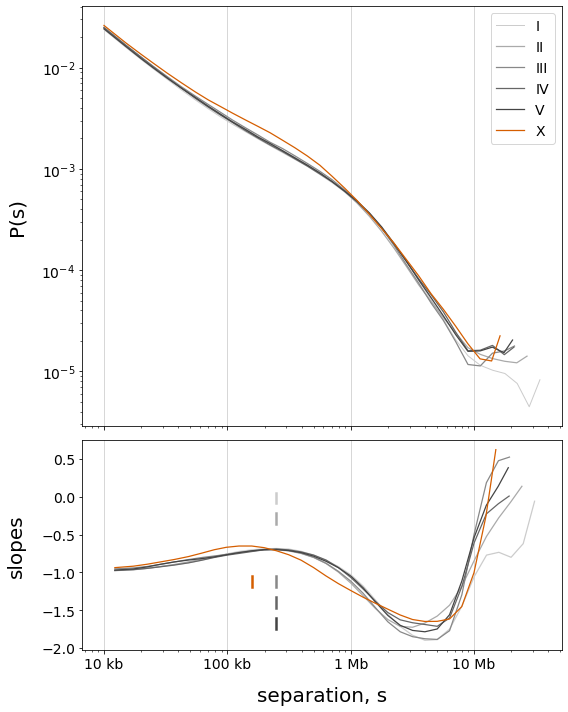

In [13]:
f, axs = plt.subplots(
    figsize=(8,10),
    ncols=1,
    nrows=2,
    sharex=True, sharey='row',
    gridspec_kw={'height_ratios':[6,3]}
)

lw=1.25
a=1
lw2=2.5
############################################ plot Ps ################################################
ax0 = axs[0]
ax0.loglog(
    I[0]['s_bp'],
    I[0]['balanced.avg'],
    'o-', markersize=0,
    label='I',
    alpha=a, color='#CCCCCC',linewidth=1
) #### plot P(s,I) on log-log space
ax0 = axs[0]
ax0.loglog(
    II[0]['s_bp'],
    II[0]['balanced.avg'],
    'o-', markersize=0,
    label='II',
    alpha=a, color='#AAAAAA',linewidth=lw
) #### plot P(s,III) on log-log space
ax0 = axs[0]
ax0.loglog(
    III[0]['s_bp'],
    III[0]['balanced.avg'],
    'o-', markersize=0,
    label='III',
    alpha=a, color='#888888',linewidth=lw
) #### plot P(s,V) on log-log space
ax0 = axs[0]
ax0.loglog(
    IV[0]['s_bp'],
    IV[0]['balanced.avg'],
    'o-', markersize=0,
    label='IV',
    alpha=a, color='#666666',linewidth=lw
) #### plot P(s,N) on log-log space
ax0 = axs[0]
ax0.loglog(
    V[0]['s_bp'],
    V[0]['balanced.avg'],
    'o-', markersize=0,
    label='V',
    alpha=a, color='#444444',linewidth=lw
) #### plot P(s,N) on log-log space
ax0.loglog(
    X[0]['s_bp'],
    X[0]['balanced.avg'],
    'o-', markersize=0,
    label='X',
    alpha=1.0, color='#D55E00',linewidth=lw
) #### plot P(s,X) on the same axis, ax0

############################################ plot Ps derivative #######################################
ax1 = axs[1]
ax1.semilogx(
    I[1]['s_bp'],
    I[1]['slope'],
    'o-', markersize=0,
    label='I',
    alpha=a,color='#CCCCCC',linewidth=lw
) #### plot log-derivative of P(s,I) on semi-log space
ax1.semilogx(
    II[1]['s_bp'],
    II[1]['slope'],
    'o-', markersize=0,
    label='II',
    alpha=a,color='#AAAAAA',linewidth=lw
) #### plot log-derivative of P(s,III) on semi-log space
ax1.semilogx(
    III[1]['s_bp'],
    III[1]['slope'],
    'o-', markersize=0,
    label='III',
    alpha=a,color='#888888',linewidth=lw
) #### plot log-derivative of P(s,V) on semi-log space
ax1.semilogx(
    IV[1]['s_bp'],
    IV[1]['slope'],
    'o-', markersize=0,
    label='IV',
    alpha=a,color='#666666',linewidth=lw
) #### plot log-derivative of P(s,N) on semi-log space
ax1.semilogx(
    V[1]['s_bp'],
    V[1]['slope'],
    'o-', markersize=0,
    label='V',
    alpha=a,color='#444444',linewidth=lw
) #### plot log-derivative of P(s,N) on semi-log space
ax1.semilogx(
    X[1]['s_bp'],
    X[1]['slope'],
    'o-', markersize=0,
    label='X',
    alpha=a,color='#D55E00',linewidth=lw
) #### plot log-derivative of P(s,X) on the same axis, ax1

######################################## do some labeling #############################################
# putting grids
ax0.grid(lw=0.5, axis = 'x')
ax1.grid(lw=0.5, axis = 'x')
#ax2.grid(lw=0.5)

# label y-axis
ax0.set_ylabel('P(s)', fontsize=20, labelpad=15)
ax1.set_ylabel('slopes', fontsize=20, labelpad=15)
ax0.tick_params(axis='y', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
#ax2.set_ylabel('P(s,X)/P(s,A)')

# format x-axis, replacing exponentials with intuitive abbreviations
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)
        
format_ticks(ax=ax1,x=True,y=False,rotate=False) # x-axis is shared, only one needs to be formatted
ax1.set_xlabel('separation, s', fontsize=20, labelpad=15)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)


# add legend
ax0.legend(fontsize=14)
plt.axvline(x = loop_size_I, color = '#CCCCCC', ymin = 0.7, ymax = 0.75, linewidth = lw2)
plt.axvline(x = loop_size_II, color = '#AAAAAA', ymin = 0.6, ymax = 0.65, linewidth = lw2)
plt.axvline(x = loop_size_III, color = '#888888', ymin = 0.3, ymax = 0.35, linewidth = lw2)
plt.axvline(x = loop_size_IV, color = '#666666', ymin = 0.2, ymax = 0.25, linewidth = lw2)
plt.axvline(x = loop_size_V, color = '#444444', ymin = 0.1, ymax = 0.15, linewidth = lw2)
plt.axvline(x = loop_size_X, color = '#D55E00', ymin = 0.3, ymax = 0.35, linewidth = lw2)
plt.tight_layout()

#plt.savefig("".join([file,"_30_",bin,"_ddc.pdf"]), format='pdf', dpi=300)